# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like, or even other programming
   languages. Your final results should be presented in this notebook, however.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import warnings
warnings.filterwarnings("ignore")
import glob
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

Using TensorFlow backend.


In [2]:
#reading all the data
L = []
for f in glob.glob('exampleco_data/*'):       
   df = pd.read_csv(f,skiprows=0)
   L.append(df.values)

In [19]:
#getting all the functions
def fail_no(x):
    fnum=[]
    for i in range(0, (len(x)-10)):
        fnum.append(abs(round(x[i]))+abs(round(x[i+1]))+abs(round(x[i+2]))+abs(round(x[i+3]))+abs(round(x[i+4]))+abs(round(x[i+5]))+abs(round(x[i+6]))+abs(round(x[i+7]))+abs(round(x[i+8]))+abs(round(x[i+9])))
    return np.where(np.array(fnum)==0)[0][0]
def fault_no(x):
    check=[]
    prms=[]
    prms2=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(abs(x)[0:100],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            check.append(results.aic)
            prms.append(param)
            prms2.append(param_seasonal)
    i=check.index(min(check))
    mod = sm.tsa.statespace.SARIMAX(abs(x)[0:100],order=prms[i],seasonal_order=prms2[i],enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    pred = results.get_prediction(start=100,end=2999)
    z=pred.predicted_mean
    y=pred.conf_int(alpha=0.05)
    return np.where(abs(x)[100:3000].reset_index(drop=True)>=y.iloc[:,1].reset_index(drop=True))[0][0]
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
       # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
fault_start_arima=[]
fault_start_lstm=[]
fail_start=[]

 I first used the data and identified that there was noise being added (or subtracted) of the magnitude  0f 250 and I corrected that issue. I then saw that there's the seasonality of 14 time periods (when we use the absolute values). The approach I took was to first identify the failure timings by checking when the value goes to 0 consecutively for 10 time periods. Then I used the data prior to that by atleast by 500 time periods and trained ARIMA and LSTM models using this data. 
 
 With ARIMA I trained the data on each of the 4 variables and built a 95% confidence interval for each of them. When the value went beyond the confidence interval, it was tagged and the minimum point of these tags (over all 4 variables) was found to get the fault timing. 
 
 With LSTM, I input the entire data and forecasted the future data of all 4 variables at once. The way to get CI in LSTM would be dropout but it would have taken time for me to build that and hence, I worked with the hacky way of getting the SD from the train data and using that to build CI and see if the values deviate away from the CI. 
 
 PS - I have used the first 100 observations to train the time series model when the failure time was <500 time periods
 
 In the following example, I have calculated the fault and fail time periods for the first 5 files. For every file, there is one fail time and 2 fault times, one according to ARIMA and another according to LSTM.
 
 Please note, the final results are in time periods for each file and thus the values would range from 0 to 3000 (the number of time periods provided for each file)

In [20]:
# Using ARIMA and LSTM to get the fault times

for i in range(5):
    #reading the data
    data=pd.DataFrame(L[i]).set_index([0]).astype('float64')

    #cleaning the data
    data["c0"]=data[1]
    data.loc[data[1]<-250,'c0']=data[data[1]<-100][1]+250
    data.loc[data[1]>250,'c0']=data[data[1]>100][1]-250

    data["c1"]=data[2]
    data.loc[data[2]<-250,'c1']=data[data[2]<-100][2]+250
    data.loc[data[2]>250,'c1']=data[data[2]>100][2]-250

    data["c2"]=data[3]
    data.loc[data[3]<-250,'c2']=data[data[3]<-100][3]+250
    data.loc[data[3]>250,'c2']=data[data[3]>100][3]-250

    data["c3"]=data[4]
    data.loc[data[4]<-250,'c3']=data[data[4]<-100][4]+250
    data.loc[data[4]>250,'c3']=data[data[4]>100][4]-250

    ######## FAIL TIME ##############
    def fail_no(x):
        fnum=[]
        for i in range(0, (len(x)-10)):
            fnum.append(abs(round(x[i]))+abs(round(x[i+1]))+abs(round(x[i+2]))+abs(round(x[i+3]))+abs(round(x[i+4]))+abs(round(x[i+5]))+abs(round(x[i+6]))+abs(round(x[i+7]))+abs(round(x[i+8]))+abs(round(x[i+9])))
        return np.where(np.array(fnum)==0)[0][0]
    f0=fail_no(data['c0'])
    f1=fail_no(data['c1'])
    f2=fail_no(data['c2'])
    f3=fail_no(data['c3'])
    fail_start.append(min(f0,f1,f2,f3))

    if fail_start[i]-500>0:
        f=fail_start[i]-500
    else:
        f=100

    ######################## ARIMA ###########################
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 14) for x in list(itertools.product(p, d, q))]
    def fault_no(x):
        check=[]
        prms=[]
        prms2=[]
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                mod = sm.tsa.statespace.SARIMAX(abs(x)[0:f],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()
                check.append(results.aic)
                prms.append(param)
                prms2.append(param_seasonal)
        i=check.index(min(check))
        mod = sm.tsa.statespace.SARIMAX(abs(x)[0:f],order=prms[i],seasonal_order=prms2[i],enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        pred = results.get_prediction(start=f,end=2999)
        z=pred.predicted_mean
        y=pred.conf_int(alpha=0.05)
        n=np.where(abs(x)[f:3000].reset_index(drop=True)>=y.iloc[:,1].reset_index(drop=True))[0]
        if n.shape[0]==0:
            n=[3000]
        return n[0]
    c0=fault_no(data['c0'])
    c1=fault_no(data['c1'])
    c2 = fault_no(data['c2'])
    c3 = fault_no(data['c3'])
    fault_start_arima.append(min(c0,c1,c2,c3)+f)


    ######################## LSTM ####################
    #Getting the data in correct format
    def split_sequences(sequences, n_steps_in, n_steps_out):
        X, y = list(), list()
        for i in range(len(sequences)):
            # find the end of this pattern
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            # check if we are beyond the dataset
            if out_end_ix > len(sequences):
                break
           # gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
            X.append(seq_x)
            y.append(seq_y)
        return array(X), array(y)
    # define input sequence
    in_seq1 = np.array(abs(data['c0'][0:f]))
    in_seq2 = np.array(abs(data['c1'][0:f]))
    in_seq3 = np.array(abs(data['c2'][0:f]))
    in_seq4 = np.array(abs(data['c3'][0:f]))
    out_seq = array([in_seq1[i]+in_seq2[i]+in_seq3[i]+in_seq4[i] for i in range(len(in_seq1))])
    # convert to [rows, columns] structure
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    in_seq3 = in_seq3.reshape((len(in_seq3), 1))
    in_seq4 = in_seq4.reshape((len(in_seq4), 1))
    out_seq = out_seq.reshape((len(out_seq), 1))
    dataset = hstack((in_seq1, in_seq2,in_seq3, in_seq4))
    n_steps_in, n_steps_out = 14, 14
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    n_features = X.shape[2]
    #Building the model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=300, verbose=0)
    #forecasting
    in_seq1 = np.array(abs(data['c0'][(f-14):f]))
    in_seq2 = np.array(abs(data['c1'][(f-14):f]))
    in_seq3 = np.array(abs(data['c2'][(f-14):f]))
    in_seq4 = np.array(abs(data['c3'][(f-14):f]))
    out_seq = array([in_seq1[i]+in_seq2[i]+in_seq3[i]+in_seq4[i] for i in range(len(in_seq1))])
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    in_seq3 = in_seq3.reshape((len(in_seq3), 1))
    in_seq4 = in_seq4.reshape((len(in_seq4), 1))
    out_seq = out_seq.reshape((len(out_seq), 1))
    x_input = hstack((in_seq1, in_seq2,in_seq3, in_seq4))
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    yhat1=yhat
    for i in range(10):
        xinput=yhat1.reshape((1, n_steps_in, n_features))
        yhat1 = model.predict(xinput, verbose=0)
        yhat=np.hstack((yhat, yhat1))
    yhat1=yhat
    for i in range(19):
        yhat=np.hstack((yhat,yhat1))
    test=pd.DataFrame(yhat.reshape(yhat.shape[1], 4))
    a=np.where((abs(data['c0'])[f:3000].reset_index(drop=True)>=test.iloc[0:(3000-f),0].reset_index(drop=True)+2*abs(data['c0'])[0:f].diff(14)[14:f].std()) | (abs(data['c0'])[f:3000].reset_index(drop=True)<=test.iloc[0:(3000-f),0].reset_index(drop=True)-2*abs(data['c0'])[0:f].diff(14)[14:f].std()) )[0][0]
    b=np.where((abs(data['c1'])[f:3000].reset_index(drop=True)>=test.iloc[0:(3000-f),1].reset_index(drop=True)+2*abs(data['c1'])[0:f].diff(14)[14:f].std()) | (abs(data['c1'])[f:3000].reset_index(drop=True)<=test.iloc[0:(3000-f),1].reset_index(drop=True)-2*abs(data['c1'])[0:f].diff(14)[14:f].std()) )[0][0]
    c=np.where((abs(data['c2'])[f:3000].reset_index(drop=True)>=test.iloc[0:(3000-f),2].reset_index(drop=True)+2*abs(data['c2'])[0:f].diff(14)[14:f].std()) | (abs(data['c2'])[f:3000].reset_index(drop=True)<=test.iloc[0:(3000-f),2].reset_index(drop=True)-2*abs(data['c2'])[0:f].diff(14)[14:f].std()) )[0][0]
    d=np.where((abs(data['c3'])[f:3000].reset_index(drop=True)>=test.iloc[0:(3000-f),3].reset_index(drop=True)+2*abs(data['c3'])[0:f].diff(14)[14:f].std()) | (abs(data['c3'])[f:3000].reset_index(drop=True)<=test.iloc[0:(3000-f),3].reset_index(drop=True)-2*abs(data['c3'])[0:f].diff(14)[14:f].std()) )[0][0]
    fault_start_lstm.append(min(a,b,c,d)+f)


The fault times for the first 5 files (in order), according to the LSTM model, are as follows -

In [21]:
fault_start_lstm

[204, 1394, 218, 101, 274]

The corresponding failure times -

In [23]:
fail_start

[397, 1738, 218, 269, 655]

The fault times, according to the ARIMA are as follows - 

In [24]:
fault_start_arima

[215, 1590, 3100, 101, 340]

We can see here that the third file has fault time as 3100, this is because the ARIMA model failed to find a fault time in the file

Checking if the data is stationary and we see that it indeed is-

In [197]:

result = adfuller(data['c0'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
#the time series is therefore static

ADF Statistic: -18.258721241522082
p-value: 2.3337974661007997e-30
Critical Values:
	1%: -3.4325536905242227
	5%: -2.862513646507894
	10%: -2.567288298246211


Using seasonal decomposition, we can see that a frequency of 14 removes the seasonal component of the data pretty well

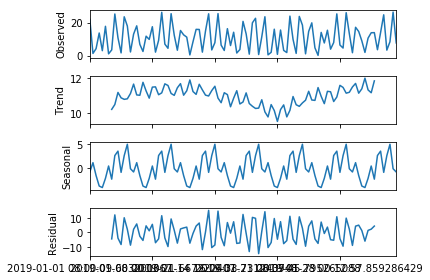

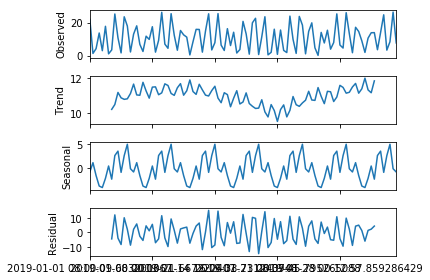

In [205]:
#seasonal decomposition 
decomposition = seasonal_decompose(abs(data[['c0']])[1:100],model='additive', freq=14) 
decomposition.plot()